In [1]:
import os
import pathlib

base_directory = os.getcwd() # store your base directory for easy reference
assignment_two_data = base_directory + '/Homework_Two_Data/'

In [2]:
# Load core libraries and utilities
import numpy as np
import matplotlib.pyplot as plt
from math_596_image_analysis_helper_functions import *
from sklearn.cluster import KMeans

# Jupyter notebook "magic"
%matplotlib inline

In [3]:
cropped_directory = assignment_two_data + '/CroppedYale/'
#cropped_image_list = file_builder(cropped_directory)

# For Windows users, you might need this instead:
win_cropped_directory = pathlib.PureWindowsPath(cropped_directory)
cropped_image_list = file_builder(win_cropped_directory)

In [4]:
# Compute projections of images along chosen modes.
# This is how we eventually built our histograms in 
# Homework 2.  
def cluster_data_maker(images_mat, mode_choices):
    zero_avg, _ = zero_mean(images_mat)
    u_modes, s_vals = mode_builder(zero_avg)
    u_modes_red = mode_selector(u_modes, s_vals, 1.)

    projected_images = u_modes_red.T @ zero_avg
    cluster_data = []
    for mode in mode_choices:
        cluster_data.append(projected_images[mode, :])
    cluster_data = np.array(cluster_data)
    
    return cluster_data

# Generate initial labels for "ground truth" data set
def mode_and_kmeans_label_maker(images_mat, num_clusters, mode_choices):
    
    cluster_data = cluster_data_maker(images_mat, mode_choices)
    kmeans = KMeans(n_clusters=num_clusters, random_state=0, n_init="auto").fit(cluster_data.T)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    return labels, centers, cluster_data  

# When we relabel, we make sure to reuse old centers so we don't get random label assignment
def mode_and_kmeans_relabel(cluster_data, num_clusters, prior_centers):
    # Note how we use prior_centers to initialize our kmeans
    kmeans = KMeans(n_clusters=num_clusters, init=prior_centers, n_init="auto").fit(cluster_data.T)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    return labels, centers, cluster_data  


In [5]:
# given partitions of data, labels, and number of clusters
# return a list each element of which has the points in each
# partition
def cluster_separation(cluster_data, labels, num_clusters):
    label_types = np.arange(num_clusters, dtype=int)
    groups = []
    for label_type in label_types:
        next_group = labels == label_type
        groups.append(cluster_data[:, next_group])
    return groups

# Plot the partitioned data.  This is set up to generate nrows*ncols plots using the add_subplot command.
# cnt starts from 0, thus the cnt+1 in add_subplot(nrows, ncols, cnt+1).
def cluster_plots(cluster_data, labels, centers, figure_handle, nrows, ncols, cnt):
    num_dims = centers.shape[1]
    num_clusters = centers.shape[0]

    colors = ['r', 'k', 'b']
    clusters = cluster_separation(cluster_data, labels, num_clusters)
    
    if num_dims == 2:
        ax = figure_handle.add_subplot(nrows, ncols, cnt+1)        
        ax.scatter(centers[:, 0], centers[:, 1], s=40., c='g', marker='x')
        for jj in range(len(clusters)): 
            ax.scatter(clusters[jj][0, :], clusters[jj][1, :], s=2., c=colors[jj])
    elif num_dims == 3:
        ax = figure_handle.add_subplot(nrows, ncols, cnt+1, projection='3d')
        ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], s=40., c='g', marker='x')
        for jj in range(len(clusters)):
            ax.scatter(clusters[jj][0, :], clusters[jj][1, :], clusters[jj][2,:], s=2., c=colors[jj])
        
    

In [6]:
def kfold_validator(cluster_data, labels, centers, num_samples, num_plots):
    tot_images = cluster_data.shape[1]
    tot_indices = np.arange(tot_images)
    num_clusters = centers.shape[0]
    rng = np.random.default_rng()

    fig = plt.figure(figsize=(8, 6))
    dif_vals = np.zeros(num_samples)   

    # choose 90% of your original images 
    samp_images = int(np.floor(.9 * tot_images))
    for jj in range(num_samples):
        # shuffle indices and take 90%
        rng.shuffle(tot_indices)
        red_indices = np.sort(tot_indices[:samp_images])

        # compute new kmeans clusters for 90% subset
        ref_labels = labels[red_indices]
        # note, we call relabel to control arbitrary label switching 
        red_labels, red_centers, red_cluster_data = mode_and_kmeans_relabel(cluster_data[:, red_indices], num_clusters, centers)     
        # compute difference in labels 
        absdifs = np.abs( red_labels - ref_labels )

        # if we have three clusters we have to be a little more clever 
        if num_clusters == 3:
            dblinds = absdifs >= 1.
            absdifs[dblinds] == 1

        # compute relative differences  
        dif_vals[jj] = np.sum(absdifs)/red_labels.size
        
        # plotting first num_plots of labeled data
        # again: nrows * ncols = num_plots
        my_nrows = 2 # this could be different.  up to you ;)
        my_ncols = int(num_plots/my_nrows)
        if jj < num_plots:
            cluster_plots(red_cluster_data, red_labels, red_centers, figure_handle=fig, nrows=my_nrows, ncols=my_ncols, cnt=jj)
                
        fig.tight_layout()
    return dif_vals

In [7]:
# Same stuff from lecture notes:

num_crp_images = len(cropped_image_list)
crp_row, crp_col = np.shape(cropped_image_list[0])
crp_image_mat = np.zeros((crp_row*crp_col, num_crp_images), dtype=np.float64)
for cnt, image in enumerate(cropped_image_list):
    crp_image_mat[:, cnt] = image.flatten()

print(f"Total number of images is: {num_crp_images}")
print(f"Pixel counts are {crp_row} by {crp_col}")

Total number of images is: 512
Pixel counts are 192 by 168


**Problem 1**: Using the cropped image list from Homework 2, following our study of using k-means clusters on the scatter plot of `projected_images[0, :]` and `projected_images[1, :]` as shown in `Applications_of_the_SVD_and_Cluster_Analysis.ipynb`, we want to study how sensisitve the labels we used are.  To do this, using the code above: 

* Remove 10% of the total images and then label the remaining 90% of the images.  Compare your labels that you generated for the full data set to your new ones (relative of course to the common 90% of images you are working with) and compute the average difference as a percentage of the total number of images in your 90% set.  

* Repeat this process `num_samps` more times by removing a different 10% of the data each time.  This should generate `num_samps` more average differences.  

* Plot `num_plots` of your results and comment upon them.  How robust are the labels?  How does this change as you change `num_samps`?  How effective would you say that our labeling scheme is?  

**Note**: All of the code above does everything you need it do already.  The question here and throughout the remainder of the assignment is what to call and when.  Likewise, how do your relative difference results vary with `num_samps`?  Why did you make the choice that you did for `num_plots`?

In [20]:
%env OMP_NUM_THREADS=2
import warnings

warnings.filterwarnings('ignore')
# To build your 90%/10% splits in the data, we shuffle our images first, then build our modes, and find our labels for the full data set relative to a fixed shuffle of the image indices.
#You will use the labels, centers, and cluster_data as your starting point to Problem 1.  

#labels = which group
#do the groups change when we change the data? (are the label robust??)
# we do want small average differences, we want to be able to use less data and get the same grouping 
rng = np.random.default_rng()
image_indices = np.arange(num_crp_images)
rng.shuffle(image_indices)
crp_image_mat = crp_image_mat[:, image_indices]
labels, centers, cluster_data = mode_and_kmeans_label_maker(crp_image_mat, 2, [0, 1])

env: OMP_NUM_THREADS=2


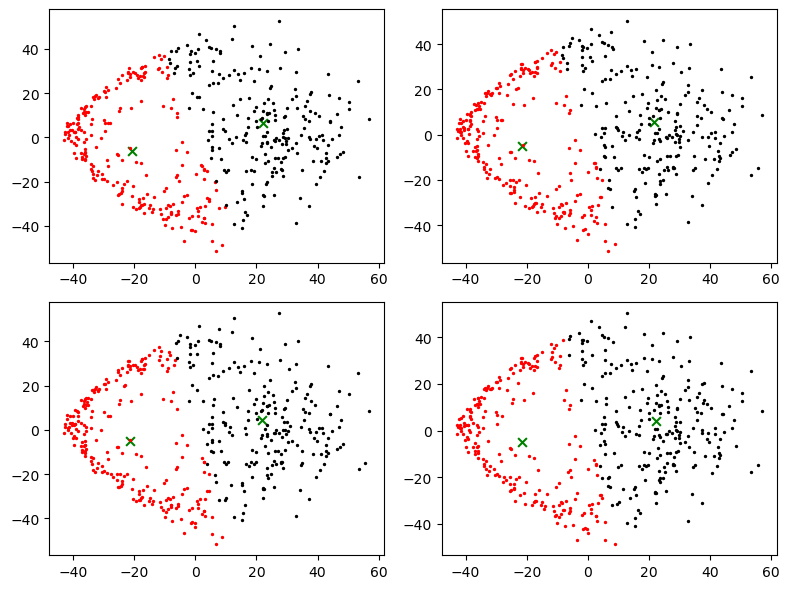

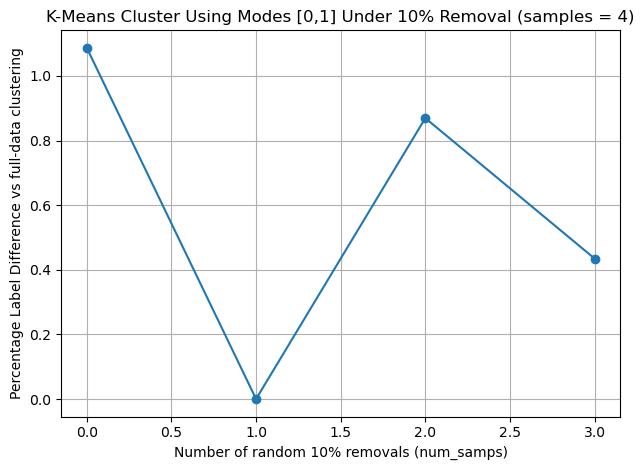

In [36]:
num_samps = 4
num_plots = 4
percent_4 = kfold_validator(cluster_data, labels, centers, num_samps, num_plots) * 100
plt.show()
plt.plot(percent_4, marker = 'o')
plt.xlabel('Number of random 10% removals (num_samps)')
plt.ylabel('Percentage Label Difference vs full-data clustering')
plt.title(f'K-Means Cluster Using Modes [0,1] Under 10% Removal (samples = {num_samps})')
plt.grid()
plt.tight_layout()
plt.show()

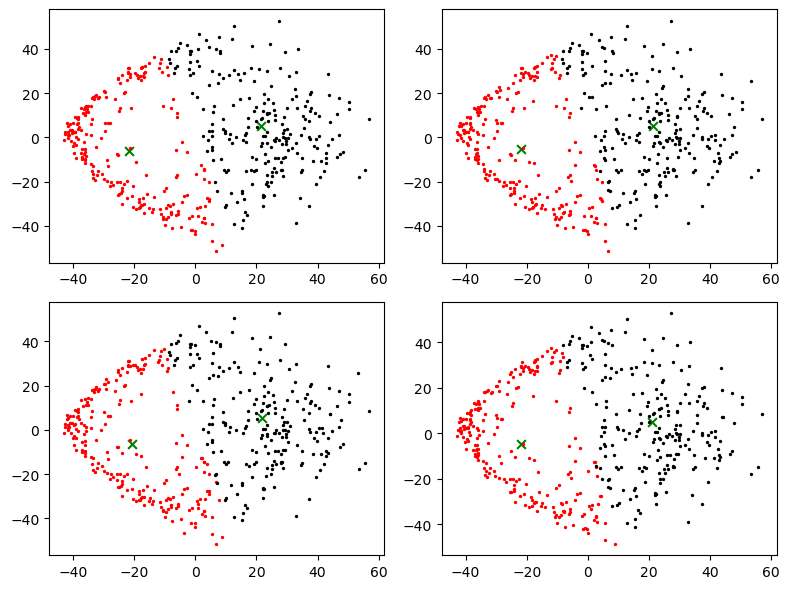

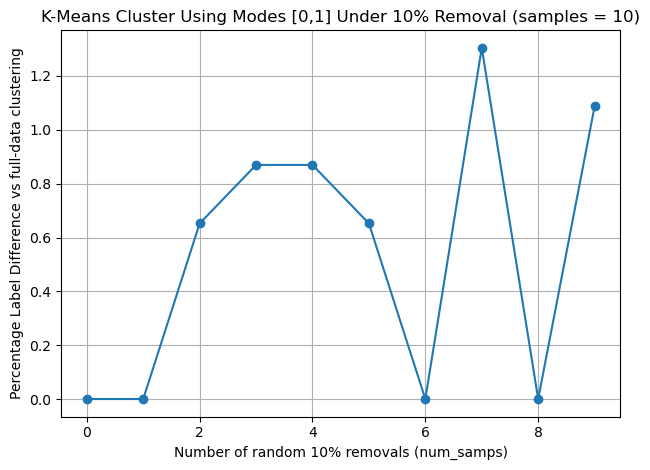

In [37]:
num_samps = 10
num_plots = 4
percent_10 = kfold_validator(cluster_data, labels, centers, num_samps, num_plots) * 100
plt.show()
plt.plot(percent_10, marker = 'o')
plt.xlabel('Number of random 10% removals (num_samps)')
plt.ylabel('Percentage Label Difference vs full-data clustering')
plt.title(f'K-Means Cluster Using Modes [0,1] Under 10% Removal (samples = {num_samps})')
plt.grid()
plt.tight_layout()
plt.show()

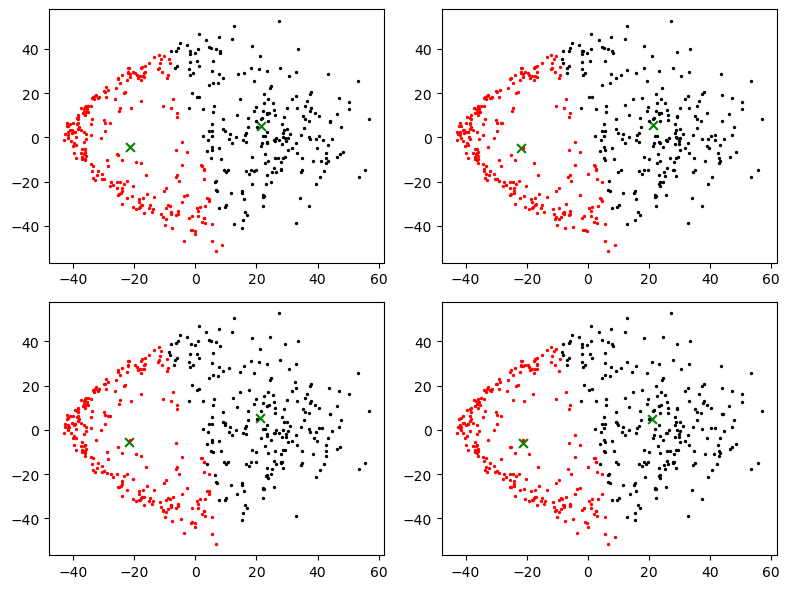

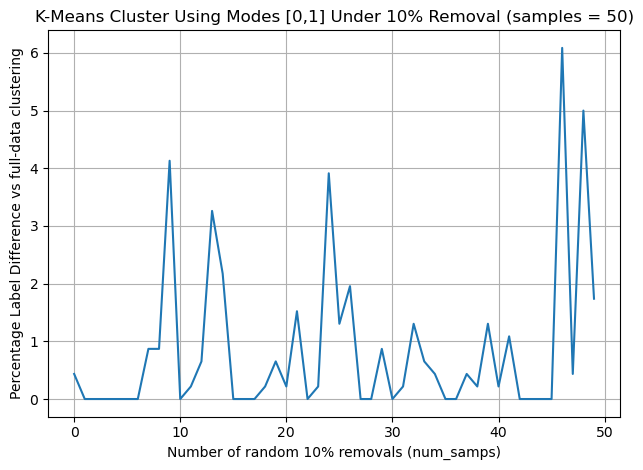

In [38]:
num_samps = 50
num_plots = 4
percent_50 = kfold_validator(cluster_data, labels, centers, num_samps, num_plots) * 100
plt.show()
plt.plot(percent_50)
plt.xlabel('Number of random 10% removals (num_samps)')
plt.ylabel('Percentage Label Difference vs full-data clustering')
plt.title(f'K-Means Cluster Using Modes [0,1] Under 10% Removal (samples = {num_samps})')
plt.grid()
plt.tight_layout()
plt.show()

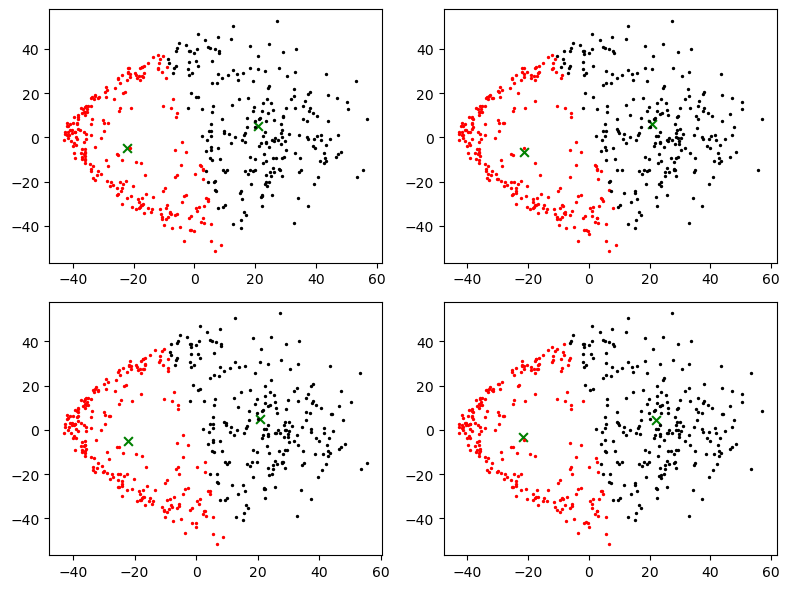

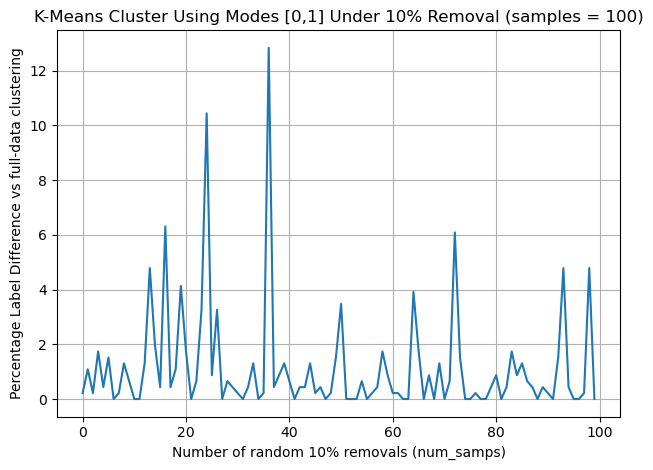

In [40]:
num_samps = 100
num_plots = 4
percent_100 = kfold_validator(cluster_data, labels, centers, num_samps, num_plots) * 100
plt.show()
plt.plot(percent_100)
plt.xlabel('Number of random 10% removals (num_samps)')
plt.ylabel('Percentage Label Difference vs full-data clustering')
plt.title(f'K-Means Cluster Using Modes [0,1] Under 10% Removal (samples = {num_samps})')
plt.grid()
plt.tight_layout()
plt.show()


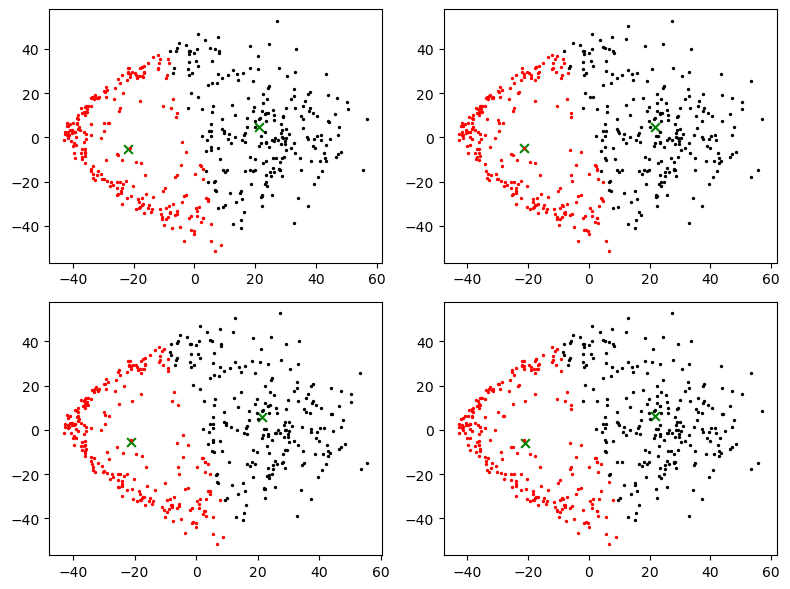

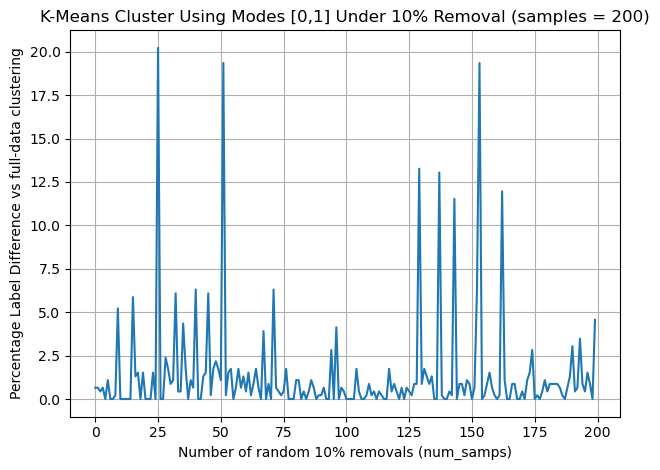

In [42]:
num_samps = 200
num_plots = 4
percent_200 = kfold_validator(cluster_data, labels, centers, num_samps, num_plots) * 100
plt.show()
plt.plot(percent_200)
plt.xlabel('Number of random 10% removals (num_samps)')
plt.ylabel('Percentage Label Difference vs full-data clustering')
plt.title(f'K-Means Cluster Using Modes [0,1] Under 10% Removal (samples = {num_samps})')
plt.grid()
plt.tight_layout()
plt.show()

## Problem 1 Comments


When randomly select 90% of the full data set 4 (num_samps) separate times, k-means was able to group the reduced data set within a 1% difference of the grouping of the full data set using the first two modes. As we increase the number of times we do a 10% random removal, we see various amounts of percent differences. By increasing num_samps to 10, we see a little bit more varitey. This makes sense because doing something 4 times is not enough to see if our grouping is robust. Still, the largest difference is under 2%, so the grouping is seemly strong. Increasing num_samps to 50, we start to see larger variations. We have an outlier run that had a 6% difference and a few reaching 4%. Overall the runs still grouped within a 2% accuracy of the full data. Doing runs of 100, 200, etc. samples , most runs are within a 6% difference. The major change when increasing num_samps was the magnitude of the outliers. At num_samps = 200, the largest outlier yield a 20% difference which only happened 3/200 times. Overall the labeling seems quiet strong. 

**Problem 2**: Repeat the above analysis using two kmeans labels and the modes `projected_images[0, :]`, `projected_images[1, :]`, and `projected_images[3, :]`.  How do your results change?  

In [43]:
rng = np.random.default_rng()
image_indices = np.arange(num_crp_images)
rng.shuffle(image_indices)
crp_image_mat = crp_image_mat[:, image_indices]
labels, centers, cluster_data = mode_and_kmeans_label_maker(crp_image_mat, 2, [0, 1, 3])

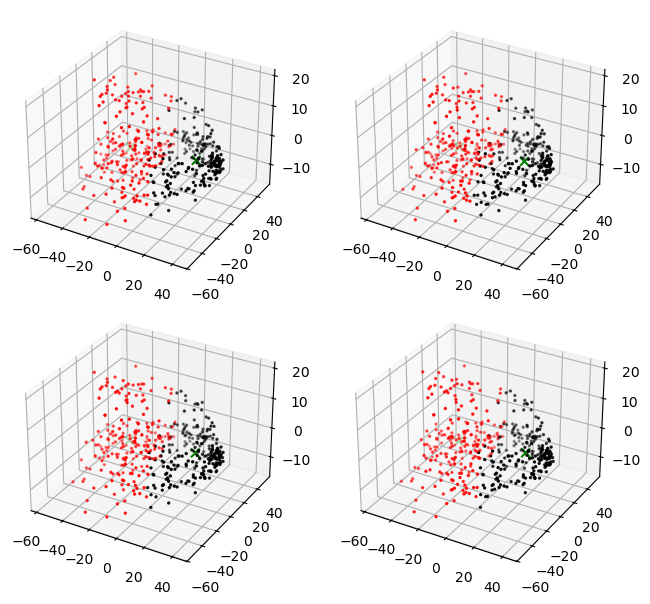

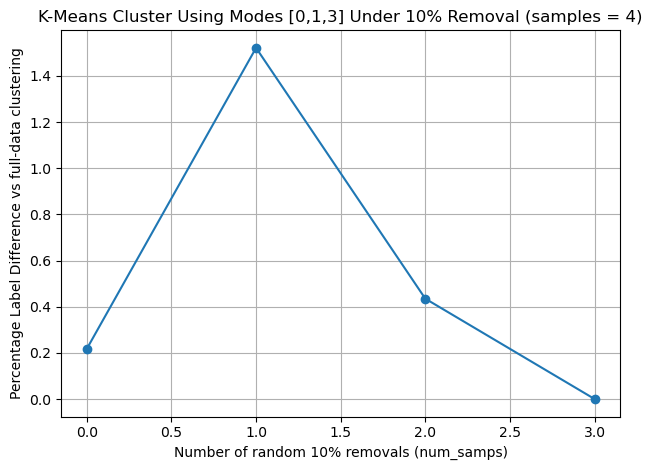

In [45]:
num_samps = 4
num_plots = 4
percent_4 = kfold_validator(cluster_data, labels, centers, num_samps, num_plots) * 100
plt.show()
plt.plot(percent_4, marker = 'o')
plt.xlabel('Number of random 10% removals (num_samps)')
plt.ylabel('Percentage Label Difference vs full-data clustering')
plt.title(f'K-Means Cluster Using Modes [0,1,3] Under 10% Removal (samples = {num_samps})')
plt.grid()
plt.tight_layout()
plt.show()

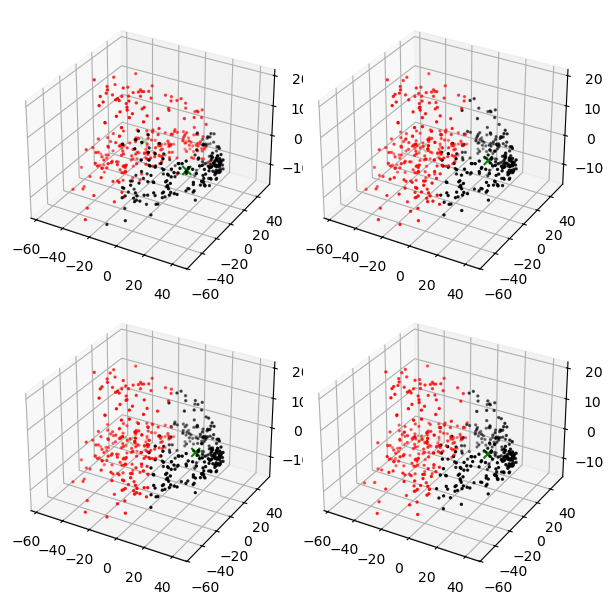

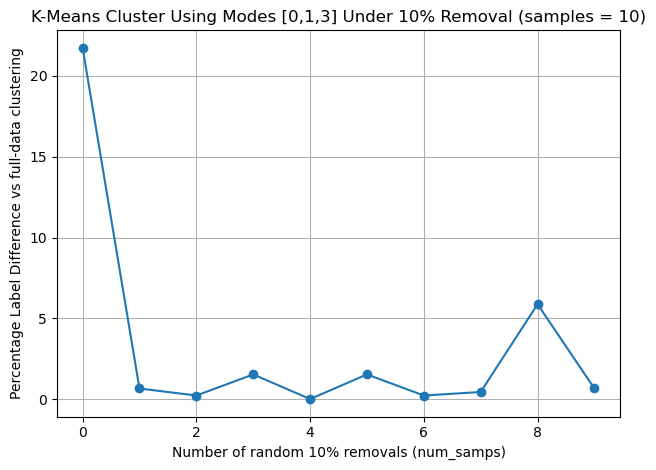

In [46]:
num_samps = 10
num_plots = 4
percent_10 = kfold_validator(cluster_data, labels, centers, num_samps, num_plots) * 100
plt.show()
plt.plot(percent_10, marker = 'o')
plt.xlabel('Number of random 10% removals (num_samps)')
plt.ylabel('Percentage Label Difference vs full-data clustering')
plt.title(f'K-Means Cluster Using Modes [0,1,3] Under 10% Removal (samples = {num_samps})')
plt.grid()
plt.tight_layout()
plt.show()

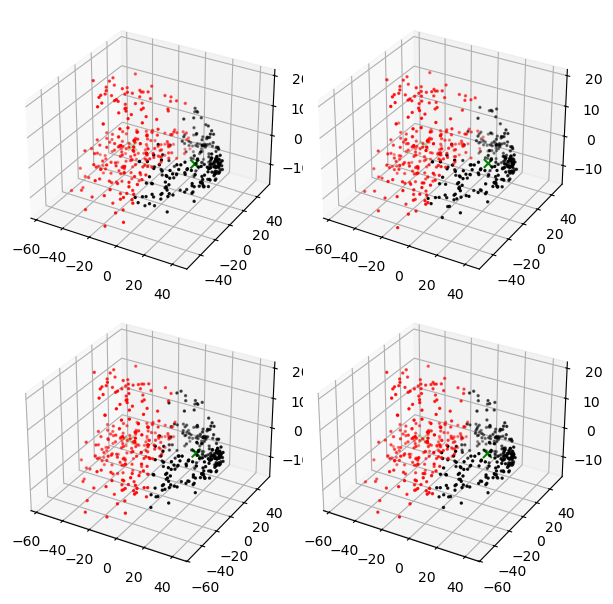

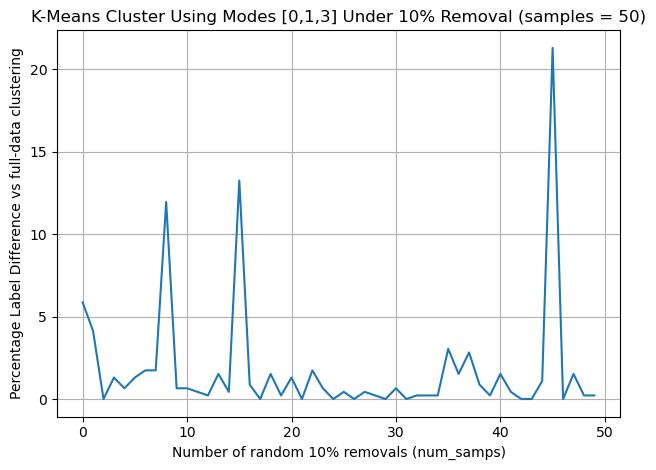

In [47]:
num_samps = 50
num_plots = 4
percent_50 = kfold_validator(cluster_data, labels, centers, num_samps, num_plots) * 100
plt.show()
plt.plot(percent_50)
plt.xlabel('Number of random 10% removals (num_samps)')
plt.ylabel('Percentage Label Difference vs full-data clustering')
plt.title(f'K-Means Cluster Using Modes [0,1,3] Under 10% Removal (samples = {num_samps})')
plt.grid()
plt.tight_layout()
plt.show()

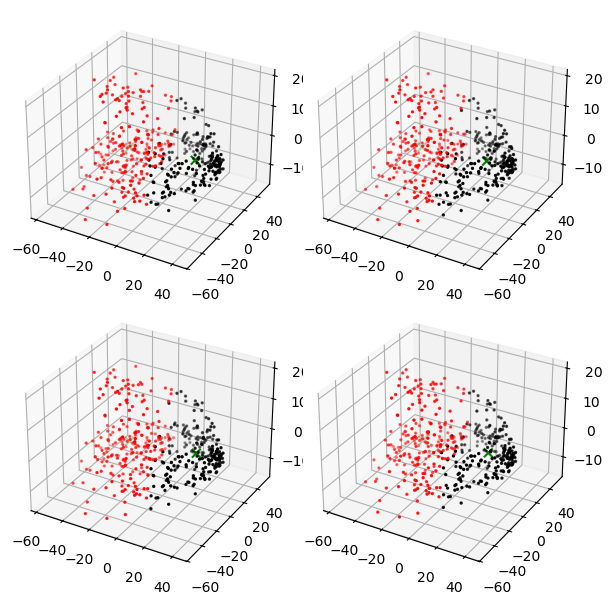

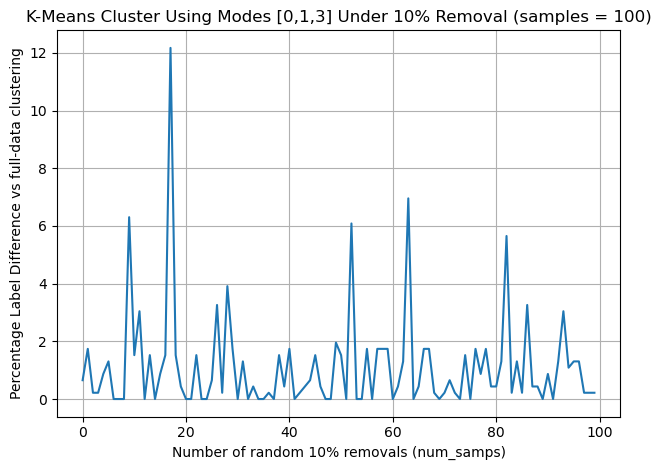

In [48]:
num_samps = 100
num_plots = 4
percent_100 = kfold_validator(cluster_data, labels, centers, num_samps, num_plots) * 100
plt.show()
plt.plot(percent_100)
plt.xlabel('Number of random 10% removals (num_samps)')
plt.ylabel('Percentage Label Difference vs full-data clustering')
plt.title(f'K-Means Cluster Using Modes [0,1,3] Under 10% Removal (samples = {num_samps})')
plt.grid()
plt.tight_layout()
plt.show()

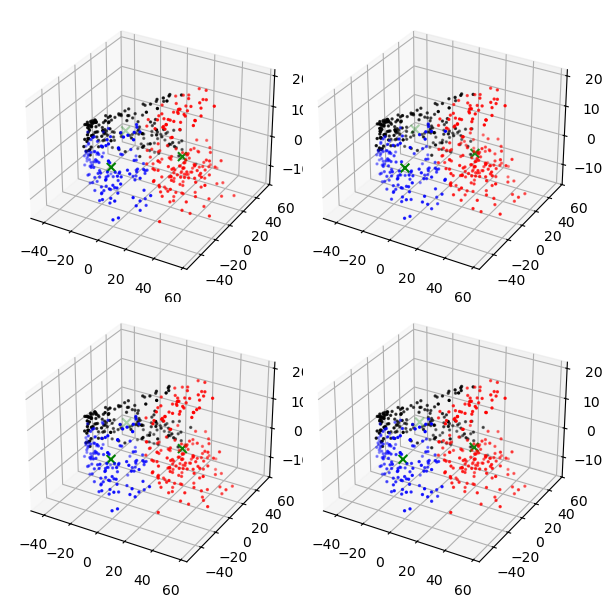

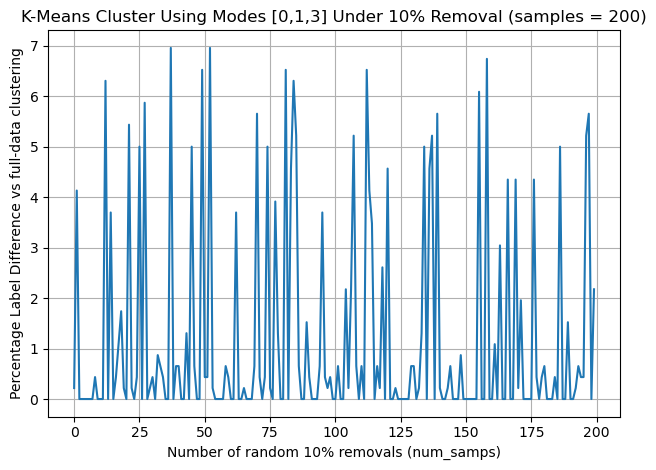

In [56]:
num_samps = 200
num_plots = 4
percent_200 = kfold_validator(cluster_data, labels, centers, num_samps, num_plots) * 100
plt.show()
plt.plot(percent_200)
plt.xlabel('Number of random 10% removals (num_samps)')
plt.ylabel('Percentage Label Difference vs full-data clustering')
plt.title(f'K-Means Cluster Using Modes [0,1,3] Under 10% Removal (samples = {num_samps})')
plt.grid()
plt.tight_layout()
plt.show()

## Problem 2 Comments

Here we repeated the same process in Problem 1 but we introduced the third mode. The num_samp choices remained the same. At 4 num_samps, the percentages correspond to the percentages in problem 1. This is because only 4 random times does not give an accurate robust measure. At 10 num_samps, we had an outlier yielding over a 20% difference and one yielding roughly 6%. The rest of the samples were under 2.5%. At num_samps = 50, we had a few outliers of 15% and 20% , while most still remained under 2.5% difference. This story continues for num_samps = 100,200. These gave a few more outliers, which is expected to increase as the number of random samples increases but overall, using 3 modes gave us a 2.5% difference to group the data into 2 labels when using 90% of the data set. Compared to only using 2 modes, it seems that there is a larger amount of outliers while the average percentage seemed to be the same, if not larger. 

**Problem 3**: Repeat the above analysis using three kmeans labels and the modes `projected_images[0, :]`, `projected_images[1, :]`, and `projected_images[3, :]`.  How do your results change?  Which would you say is the best labeling scheme?  

In [50]:
rng = np.random.default_rng()
image_indices = np.arange(num_crp_images)
rng.shuffle(image_indices)
crp_image_mat = crp_image_mat[:, image_indices]
labels, centers, cluster_data = mode_and_kmeans_label_maker(crp_image_mat, 3, [0, 1,3])

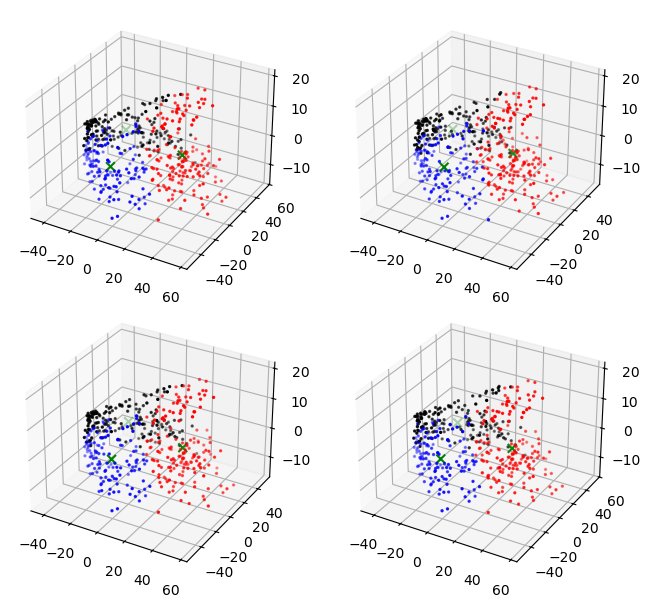

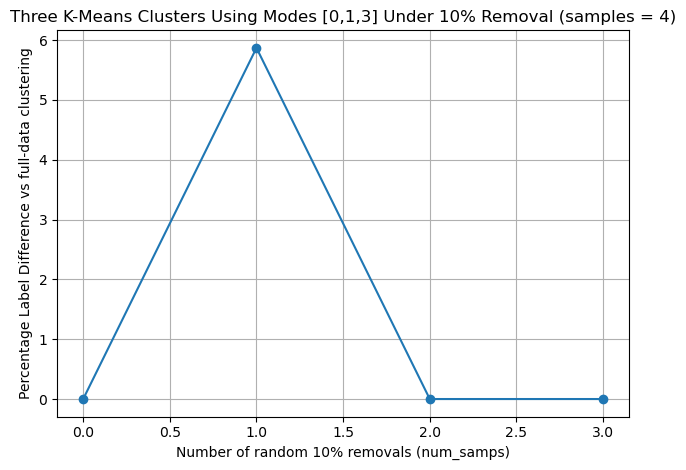

In [51]:
num_samps = 4
num_plots = 4
percent_4 = kfold_validator(cluster_data, labels, centers, num_samps, num_plots) * 100
plt.show()
plt.plot(percent_4, marker = 'o')
plt.xlabel('Number of random 10% removals (num_samps)')
plt.ylabel('Percentage Label Difference vs full-data clustering')
plt.title(f'Three K-Means Clusters Using Modes [0,1,3] Under 10% Removal (samples = {num_samps})')
plt.grid()
plt.tight_layout()
plt.show()

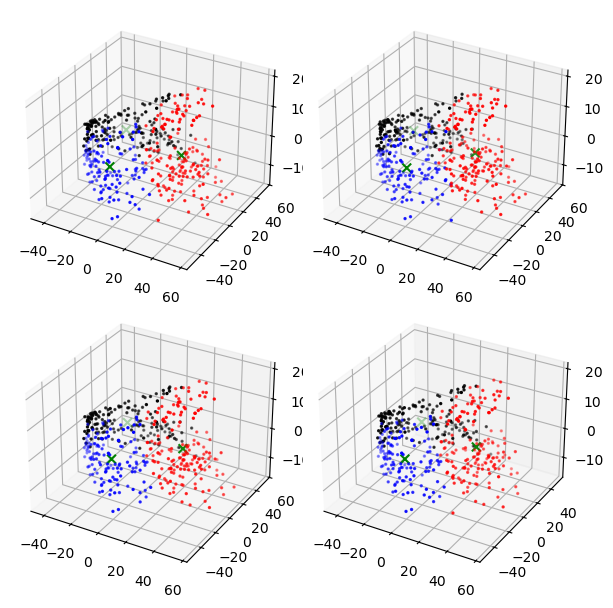

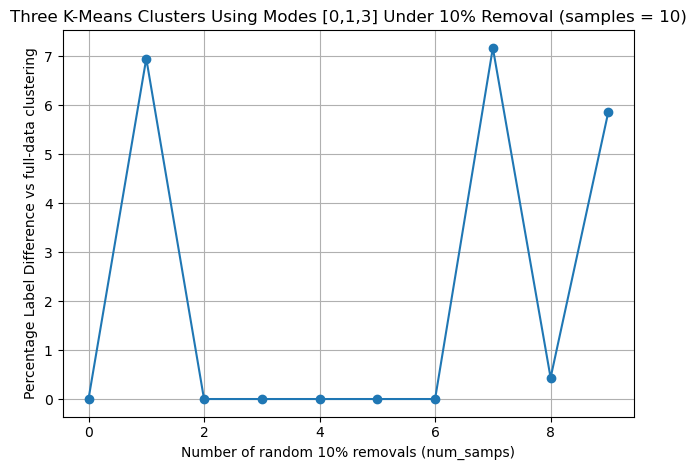

In [52]:
num_samps = 10
num_plots = 4
percent_10 = kfold_validator(cluster_data, labels, centers, num_samps, num_plots) * 100
plt.show()
plt.plot(percent_10, marker = 'o')
plt.xlabel('Number of random 10% removals (num_samps)')
plt.ylabel('Percentage Label Difference vs full-data clustering')
plt.title(f'Three K-Means Clusters Using Modes [0,1,3] Under 10% Removal (samples = {num_samps})')
plt.grid()
plt.tight_layout()
plt.show()

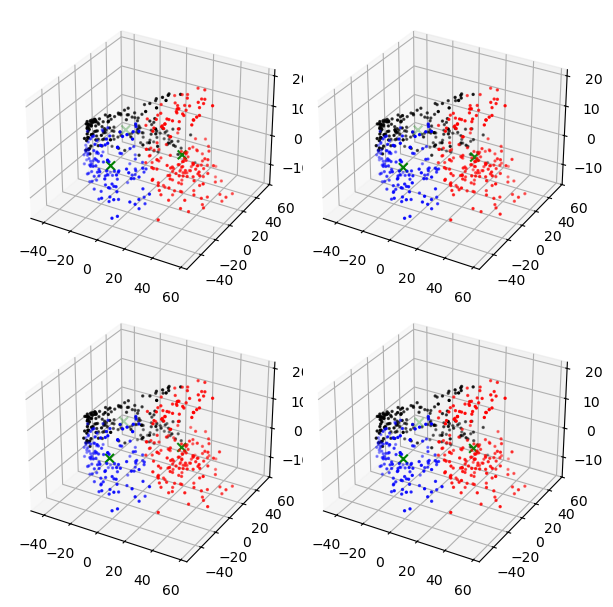

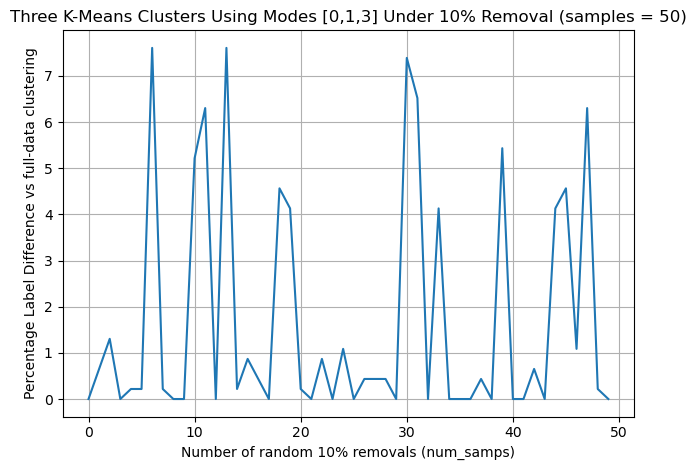

In [53]:
num_samps = 50
num_plots = 4
percent_50 = kfold_validator(cluster_data, labels, centers, num_samps, num_plots) * 100
plt.show()
plt.plot(percent_50)
plt.xlabel('Number of random 10% removals (num_samps)')
plt.ylabel('Percentage Label Difference vs full-data clustering')
plt.title(f'Three K-Means Clusters Using Modes [0,1,3] Under 10% Removal (samples = {num_samps})')
plt.grid()
plt.tight_layout()
plt.show()

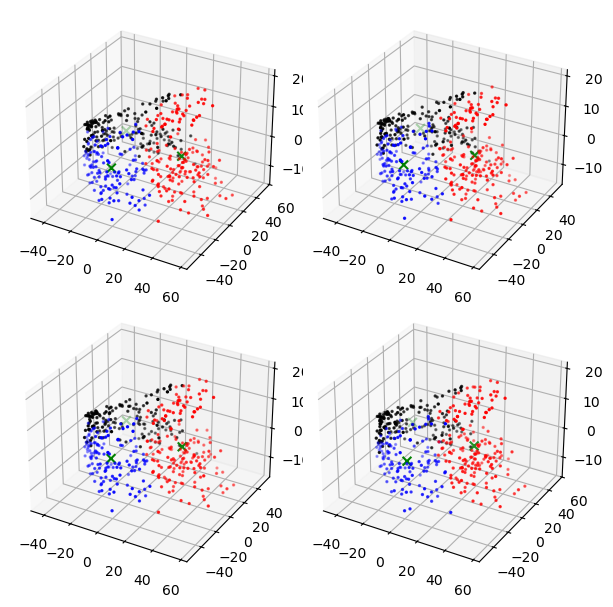

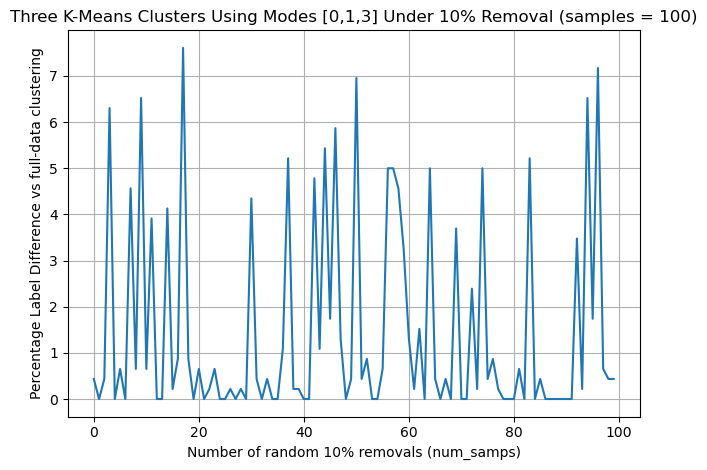

In [54]:
num_samps = 100
num_plots = 4
percent_100 = kfold_validator(cluster_data, labels, centers, num_samps, num_plots) * 100
plt.show()
plt.plot(percent_100)
plt.xlabel('Number of random 10% removals (num_samps)')
plt.ylabel('Percentage Label Difference vs full-data clustering')
plt.title(f'Three K-Means Clusters Using Modes [0,1,3] Under 10% Removal (samples = {num_samps})')
plt.grid()
plt.tight_layout()
plt.show()

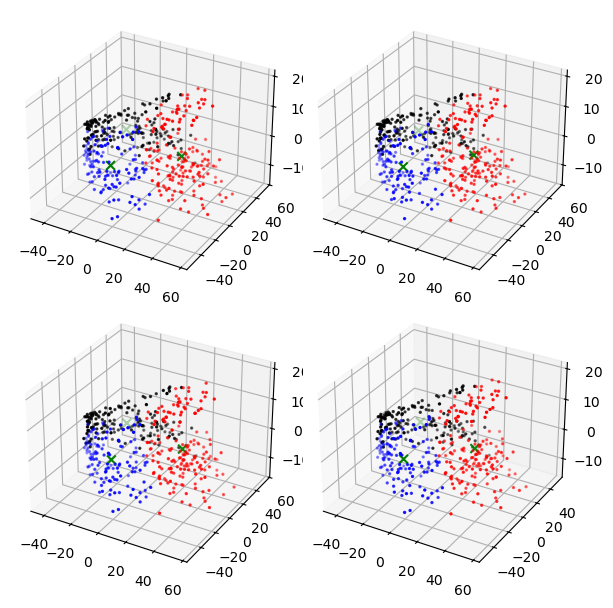

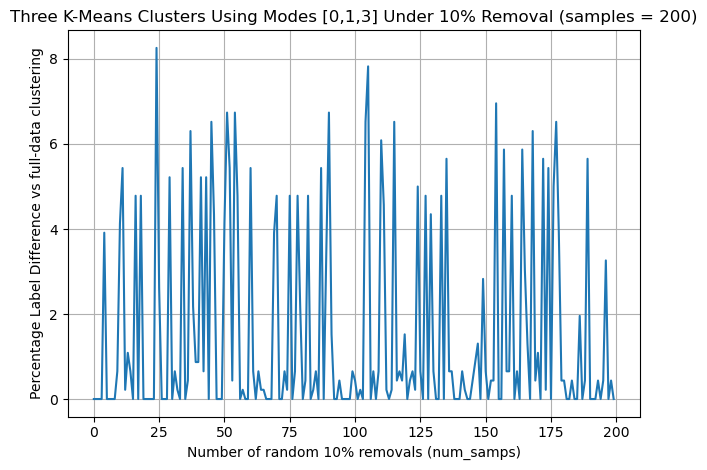

In [55]:
num_samps = 200
num_plots = 4
percent_200 = kfold_validator(cluster_data, labels, centers, num_samps, num_plots) * 100
plt.show()
plt.plot(percent_200)
plt.xlabel('Number of random 10% removals (num_samps)')
plt.ylabel('Percentage Label Difference vs full-data clustering')
plt.title(f'Three K-Means Clusters Using Modes [0,1,3] Under 10% Removal (samples = {num_samps})')
plt.grid()
plt.tight_layout()
plt.show()

## Problem 3 Comments

In problem 3, we are working with 3 modes and now using k-means to make 3 clusters. Cutting to the chase, the outliers are much smaller at num_samps large enough (100,200). They all fall just under a 8% difference from the original data. This is ideal. Having a low percentage difference means that even without a random 10% of our data, the labels are strong and have a clear distinction. The graph appears to have rining but when we look at the scale of the ringing, its not so bad. Osciliating between 0-8% is not a big deal here unless our upper bound was much greater. 3 labels and 3 modes seems to be the best labeling scheme. Introducing a third mode means new information of the data and another label allows for disticnt grouping. Im curious to see what the percentage differences would be if we did 3 groups with only 2 modes.